# Chapter 8 Tree-Based Methods Exercises

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image
from io import StringIO
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

from src import ch8_utils

%matplotlib inline

### 8.2. Why is boosting using depth-one trees (or stumps) analogous to an additive model?

An additive model is one in which each variable is applied its own formula. "Stumped Boosting" more or less performs the same exercise by splitting one feature for each tree.


### 8.5. Ten bootstrapped samples question.

If I use the **majority-vote approach**, the predicted classification is **red**. If I apply **average probability**, the predicted classification is **green**.

In [2]:
q5_arr = np.array([0.1, 0.15, 0.2, 0.2, 0.55, 0.6, 0.6, 0.65, 0.7, 0.75])
q5_arr.mean()

0.45

### 8.5. A detailed explanation of the algorithm that is used to fit a regression tree.

- 

## Conceptual

### 8.7. Create a plot displaying the test error resulting from a random forest on the Boston dataset for a more comprehensive range of values for "max_features" and "n_estimators."

In [3]:
url_path = os.path.abspath('..')
boston = pd.read_csv(url_path + '/data/Boston.csv')

X = boston.drop('medv', axis=1)
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [4]:
num_trees = np.arange(1, 502, 50)
num_features = np.arange(2, X_train.shape[1], 2)
rf_mse_df = pd.DataFrame(index=num_trees)

for feature_count in num_features:
    mse_tmp_arr = []
    for tree_count in num_trees:
        regr = RandomForestRegressor(n_estimators=tree_count, max_features=feature_count)
        regr.fit(X_train, y_train)
        pred = regr.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        mse_tmp_arr.append(mse)
    
    rf_mse_df[str(feature_count)+ '_features'] = pd.Series(mse_tmp_arr,index=num_trees)

In [5]:
rf_mse_df

,2_features,4_features,6_features,8_features,10_features,12_features
1,55.215415,42.024743,26.498893,25.192174,27.358379,29.105336
51,14.341740,12.283266,12.237940,11.543268,12.011855,12.233979
101,15.668220,12.780787,11.516935,11.796489,11.739280,11.728906
151,15.187121,13.201952,11.167172,11.644967,11.522592,11.685854
201,15.379148,12.538537,11.883133,11.154487,11.910715,11.539458
251,16.061622,12.598581,11.711530,11.065116,11.385637,11.789134
301,14.917009,12.655231,11.705729,11.303302,11.056022,11.838706
351,15.470831,12.224789,11.700934,11.346411,11.510185,11.600094
401,14.915163,12.296570,11.516710,11.715870,11.469228,11.510397
451,15.408147,12.268891,11.828612,11.551939,11.532823,11.674343


In [6]:
rf_mse_df.min()

2_features     14.341740
4_features     12.224789
6_features     11.167172
8_features     11.065116
10_features    11.056022
12_features    11.510397
dtype: float64

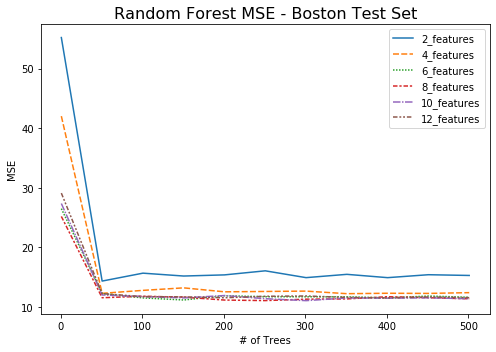

In [7]:
fig, ax = plt.subplots(figsize=(7,5))

sns.lineplot(data=rf_mse_df)
ax.set_title('Random Forest MSE - Boston Test Set', fontsize=16)
ax.set_xlabel('# of Trees')
ax.set_ylabel('MSE')
fig.tight_layout();

The lowest test MSE of **11.072796** was acehieved using **351 estimators** and **6 features**. In general, the models with **>=6 features** performed similary when **>= 51 estimators**. When using 12 features, there seemed to be a bit of overfitting as the MSE increased.

## 8.8. Apply a regression to the Carseats dataset to predict sales.

In [12]:
url_path = os.path.abspath('..')
carseats = pd.read_csv(url_path + '/data/Carseats.csv')

# Feature engineering
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = carseats['Urban'].map({'No': 0, 'Yes':1})
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1})

carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,0,42,17,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1
4,4.15,141,64,3,340,128,0,38,13,1,0


In [13]:
X = carseats.drop('Sales', axis=1)
y = carseats['Sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [20]:
dtree_regr = DecisionTreeRegressor(max_depth = 5)
dtree_regr.fit(X_train, y_train)
pred = dtree_regr.predict(X_test)

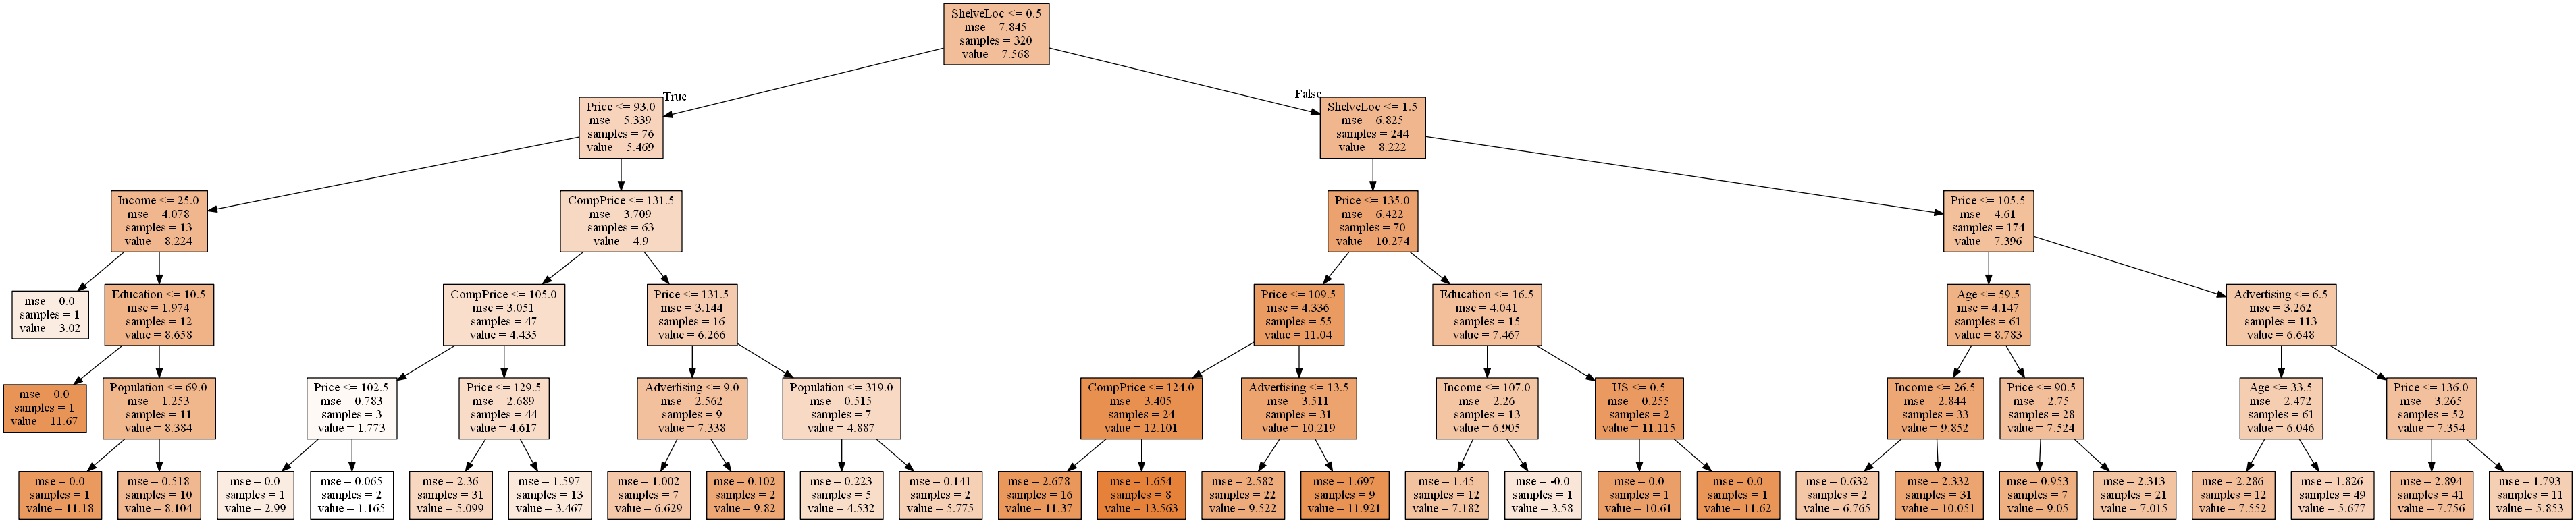

In [21]:
tree_viz, = ch8_utils.print_tree(dtree_regr, X_train.columns, class_names=None, filled=True)
Image(tree_viz.create_png())

In [22]:
print('Decision Tree MSE: {:.4}'.format(mean_squared_error(y_test, pred)))

Decision Tree MSE: 5.702


It seems that the sales of carseats is more influenced by adveristing/marketing than product quality/safety. In general, the better the shelve base, the greater the sales. Also, the more affluent the market/consumer - e.g., income and competitive product price - the greater the sales.

In summary, if a company targets the lower economic class, the less goods it is expected to sell

#### Use cross-validation to determine optimal level of tree complexity.

In [34]:
max_depth_arr = np.arange(1, 11)
avg_mse_arr = []
cross_val_df = pd.DataFrame()

for depth in max_depth_arr:
    regr = DecisionTreeRegressor(max_depth=depth)
    c_val_arr = cross_val_score(regr, X_train, y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    mse = -1 * np.mean(c_val_arr)
    avg_mse_arr.append(mse)
    cross_val_df[str(depth) + '_node'] = c_val_arr

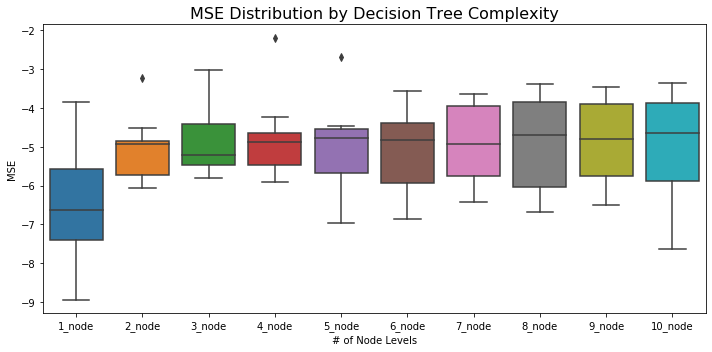

In [35]:
fig, ax = plt.subplots(figsize=(10,5))

sns.boxplot(data=cross_val_df, ax=ax)
ax.set_title('MSE Distribution by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();

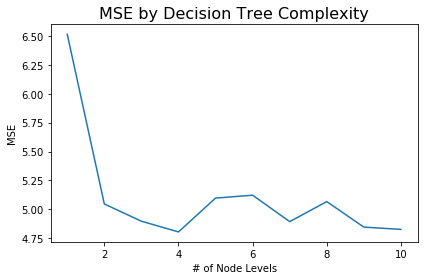

In [30]:
fig, ax = plt.subplots(figsize=(6,4))

sns.lineplot(x=max_depth_arr, y=avg_mse_arr, ax=ax)
ax.set_title('Avg MSE by Decision Tree Complexity', fontsize=16)
ax.set_xlabel('# of Node Levels')
ax.set_ylabel('MSE')
fig.tight_layout();